# Mt Wilson Sunspot database 1917-1985

From the readme: 

> Sunspot umbral position and area information were digitized from the Mount Wilson daily white-light solar images some years ago (Howard, Gilman, and Gilman, 1984). These photographic images exist in a series that extends from 1917 through the present time. The digitized data extend from 1917 through 1985. Details about the observations, the measurement procedure, and the analysis techniques used earlier may be obtained from the earlier reference (Howard, Gilman, and Gilman, 1984).

These data were first published in [Howard, Gilman, and Gilman, 1984](http://adsabs.harvard.edu/abs/1984ApJ...283..373H). The data are accessible online [here](http://www.ngdc.noaa.gov/stp/solar/sunspotregionsdata.html).

In [28]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 14

import matplotlib.pyplot as plt
from glob import glob

paths = glob('/Users/bmmorris/data/Mt_Wilson_Tilt/*/gspot??.dat')

from astropy.time import Time
import astropy.units as u
import string
from astropy.table import Table

def split_interval(string, n, cast_to_type=float):
    return [cast_to_type(string[i:i+n]) for i in range(0, len(string), n)]

base_time = Time('1915-01-01')
all_years_array = []

header = ("jd n_spots_leading n_spots_following n_spots_day_1 n_spots_day_2 "
          "rotation_rate latitude_drift area_weighted_latitude_day_1 area_weighted_longitude_day_1 "
          "area_weighted_longitude_day_2 area_day_1 area_day_2 tilt_day_1 delta_polarity_separation "
          "area_weighted_longitude_day_1_leading area_weighted_longitude_day_1_following "
          "area_weighted_latitude_day_1_leading area_weighted_latitude_day_1_following "
          "area_leading area_following area_weighted_longitude_day_2_leading " 
          "area_weighted_longitude_day_2_following delta_tilt").split()

for path in paths:
    f = open(path).read().splitlines()

    n_rows = len(f) // 3
    n_columns = 23
    yearly_array = np.zeros((n_rows, n_columns))

    for i in range(n_rows):
        # First five ints specify time, afterwards specify sunspot data
        int_list = split_interval(f[0+i*3][:18], 2, int)
        month, day, year_minus_1900, hour, minute = int_list[:5]
        year = year_minus_1900 + 1900
        jd = Time("{year:d}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}"
                  .format(**locals())).jd
        row = [jd] + int_list[5:] + split_interval(f[1+i*3], 7) + split_interval(f[2+i*3][1:], 7)
        yearly_array[i, :] = row

    all_years_array.append(yearly_array)

table = Table(np.vstack(all_years_array), names=header)

In [17]:
table

jd,n_spots_leading,n_spots_following,n_spots_day_1,n_spots_day_2,rotation_rate,latitude_drift,area_weighted_latitude_day_1,area_weighted_longitude_day_1,area_weighted_longitude_day_2,area_day_1,area_day_2,tilt_day_1,delta_polarity_separation,area_weighted_longitude_day_1_leading,area_weighted_longitude_day_1_following,area_weighted_latitude_day_1_leading,area_weighted_latitude_day_1_following,area_leading,area_following,area_weighted_longitude_day_2_leading,area_weighted_longitude_day_2_following,delta_tilt
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2421232.78125,1.0,1.0,2.0,3.0,13.151,0.417,13.142,-11.249,0.314,19.615,13.818,-25.35,-0.372,-10.382,-11.392,13.542,13.076,2.778,16.837,0.919,0.269,-2.74
2421232.78125,1.0,1.0,2.0,2.0,13.568,0.464,13.207,-4.112,7.847,9.468,20.938,13.468,0.11,-3.352,-4.209,13.029,13.229,1.068,8.4,7.863,6.944,-36.03
2421232.78125,1.0,3.0,4.0,12.0,12.176,1.184,13.705,18.61,29.247,46.216,58.587,-2.183,0.829,19.616,17.678,13.742,13.67,22.228,23.988,30.838,28.035,-0.8
2421233.83056,2.0,1.0,3.0,2.0,13.864,0.778,13.538,0.314,13.619,13.818,9.298,-28.093,0.147,0.919,0.269,13.852,13.515,0.949,12.869,14.261,13.404,12.33
2421233.83056,1.0,1.0,2.0,3.0,14.073,0.093,13.648,7.847,21.368,20.938,10.639,-22.565,-0.434,7.863,6.944,13.654,13.283,20.572,0.366,21.397,21.17,-43.1
2421233.83056,2.0,10.0,12.0,5.0,14.615,0.466,14.829,29.247,43.327,58.587,33.791,-2.981,-0.788,30.838,28.035,14.909,14.768,25.322,33.264,44.099,42.146,-9.04
2421234.79792,0.0,0.0,1.0,4.0,13.76,0.132,-22.199,-28.179,-15.905,3.542,2.573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.143,0.0
2421234.79792,1.0,1.0,2.0,3.0,14.281,-0.386,14.341,13.619,26.394,9.298,20.175,-15.763,-0.251,14.261,13.404,14.516,14.282,2.331,6.967,26.754,26.136,4.41
2421234.79792,1.0,2.0,3.0,3.0,14.197,-0.751,13.744,21.368,34.063,10.639,14.355,-65.662,0.493,21.397,21.17,13.805,13.319,9.298,1.34,34.45,33.594,30.02


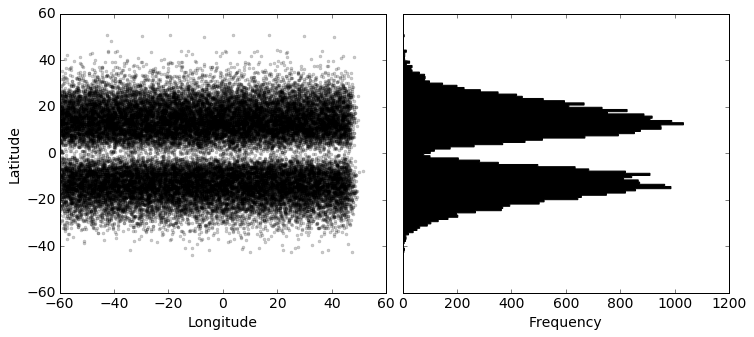

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(table['area_weighted_longitude_day_1'], 
           table['area_weighted_latitude_day_1'], 'k.', alpha=0.2)
ax[1].hist(table['area_weighted_latitude_day_1'], 100, 
           histtype='stepfilled', color='k', orientation='horizontal')

ax[0].set(xlabel='Longitude', ylabel='Latitude')
ax[1].set(xlabel='Frequency')
fig.subplots_adjust(wspace=0.05)
plt.show()

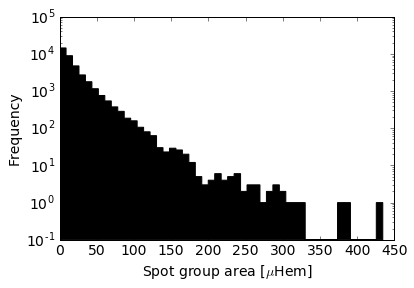

In [30]:
plt.hist(table['area_day_1'], 50, log=True, histtype='stepfilled', color='k')
plt.xlabel('Spot group area [$\mu$Hem]')
plt.ylabel('Frequency')
plt.show()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


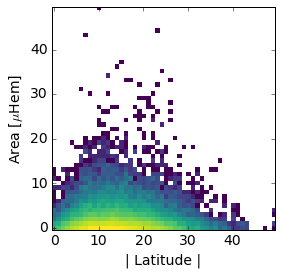

In [31]:
img, xedges, yedges = np.histogram2d(table['area_day_1'], 
                                     np.abs(table['area_weighted_latitude_day_1']), 50)
plt.imshow(np.log(img), cmap=plt.cm.viridis, interpolation='nearest', origin='lower')
plt.xlabel('| Latitude |')
plt.ylabel('Area [$\mu$Hem]')
plt.show()

[<matplotlib.text.Text at 0x11741ecf8>, <matplotlib.text.Text at 0x115393be0>]

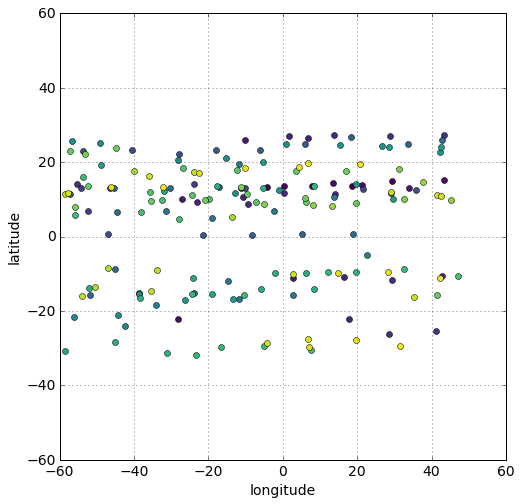

In [32]:
unique_dates = np.sort(np.unique(table['jd']))


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)#, projection='hammer')

n_days = 50
cmap = lambda x: plt.cm.viridis(x/n_days)
for i, day in enumerate(unique_dates[:n_days]):
    day = table[table['jd'] == day]

    ax.plot(day['area_weighted_longitude_day_1'], 
            day['area_weighted_latitude_day_1'], 'o', color=cmap(i))
ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])
ax.grid()
ax.set(xlabel='longitude', ylabel='latitude')

### Modeling the distribution of starspot areas

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


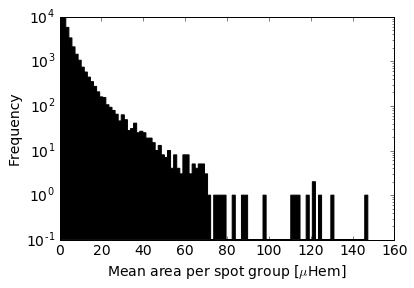

In [33]:
area_per_spot = table['area_day_1'].data/table['n_spots_day_1'].data
not_inf = ~np.isinf(area_per_spot)

plt.hist(area_per_spot[not_inf], 100, log=True, histtype='stepfilled', color='k')
plt.xlabel('Mean area per spot group [$\mu$Hem]')
plt.ylabel('Frequency')
plt.show()

<Container object of 3 artists>

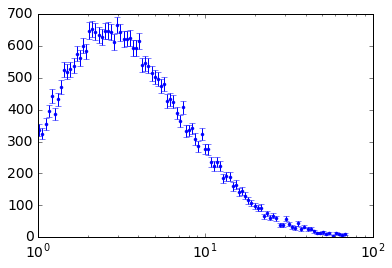

In [34]:
alledges = np.logspace(np.log10(1), np.log10(80-10), 100)
bin_centers = 0.5*(alledges[:-1] + alledges[1:])
n_spots_per_area_bin = np.zeros_like(bin_centers)
n_spots_per_area_bin_err = np.zeros_like(bin_centers)

for i in range(len(bin_centers)):
    within_bin = ((alledges[i] < area_per_spot[not_inf]) & 
                  (alledges[i+1] > area_per_spot[not_inf]))
    n_spots_per_area_bin[i] = np.count_nonzero(within_bin)
    n_spots_per_area_bin_err[i] = np.sqrt(n_spots_per_area_bin[i])
    
fig, ax = plt.subplots()
#ax.set_yscale("log")#, nonposy='clip')
ax.set_xscale("log")
ax.errorbar(bin_centers, n_spots_per_area_bin, n_spots_per_area_bin_err, fmt='.')


[<matplotlib.text.Text at 0x113b89c50>, <matplotlib.text.Text at 0x116cdea58>]

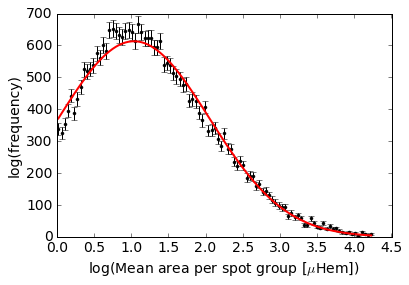

In [35]:
from scipy.optimize import leastsq

def fit_model(p, x):
    a, x0, sigma = p
    return a * np.exp(-0.5 * (x - x0)**2 / sigma**2)

log_bins = np.log(bin_centers)

def chi2(p, x):
    return (fit_model(p, x) - n_spots_per_area_bin) / n_spots_per_area_bin_err

initp = [600, 1.0, 1.0]
bestp, success = leastsq(chi2, initp, args=(log_bins,))

fig, ax = plt.subplots()
ax.errorbar(log_bins, n_spots_per_area_bin, n_spots_per_area_bin_err, fmt='k.')
ax.plot(log_bins, fit_model(bestp, log_bins), color='r', lw=2)
ax.set(xlabel="log(Mean area per spot group [$\mu$Hem])", ylabel="log(frequency)")

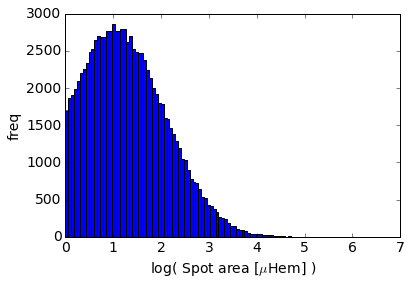

In [36]:
n_samples = 100000
def draw_samples_from_area_dist(n_samples, lower_limit=1, upper_limit=10**4.5):
    samples = []
    while len(samples) < n_samples:
        sample = np.random.lognormal(mean=bestp[1], sigma=bestp[2])
        if sample > lower_limit and sample < upper_limit: 
            samples.append(sample)
    return np.array(samples)

fig, ax = plt.subplots()
ax.hist(np.log(draw_samples_from_area_dist(n_samples)), 100)
ax.set(xlabel="log( Spot area [$\mu$Hem] )", ylabel="freq")
plt.show()

Area in a hemisphere: 

$$A_{hemisphere} = 2\pi R_*^2$$

Area in a spot in units of spot radii: 

$$A_{spot} = \pi R_{spot}^2$$

Area in a spot in units of hemispheres: 

$$ A_{sp,hem} = \frac{\pi R_{spot}^2}{2\pi R_*^2} = \frac{1}{2} \left(\frac{R_{spot}}{R_*}\right)^2$$

Radius of a spot in units of stellar radii given the spot area in hemispheres:

$$ R_{spot} / R_* = \sqrt{2 A_{sp,hem}} $$

### How big is a typical sunspot compared to HAT-P-11's proportional cross-section?

[<matplotlib.text.Text at 0x117003668>, <matplotlib.text.Text at 0x117c5cfd0>]

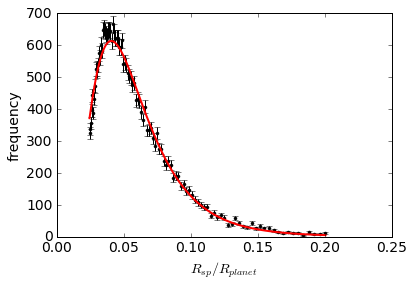

In [37]:
rspot_rstar = np.sqrt(1e-6 * 2 * np.exp(log_bins))

rp_rs = 0.058330305324663184

fig, ax = plt.subplots()
ax.errorbar(rspot_rstar / rp_rs, n_spots_per_area_bin, n_spots_per_area_bin_err, fmt='k.')
ax.plot(rspot_rstar / rp_rs, fit_model(bestp, log_bins), color='r', lw=2)
ax.set(xlabel="$R_{sp}/R_{planet}$", ylabel="frequency")

### How big is a typical sunspot ?

[<matplotlib.text.Text at 0x117419eb8>, <matplotlib.text.Text at 0x11700f828>]

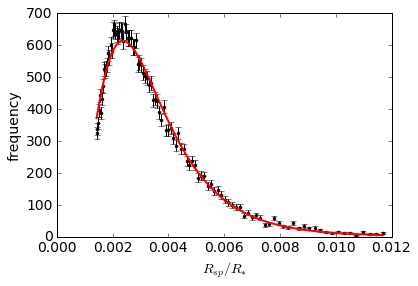

In [38]:
fig, ax = plt.subplots()
ax.errorbar(rspot_rstar, n_spots_per_area_bin, n_spots_per_area_bin_err, fmt='k.')
ax.plot(rspot_rstar, fit_model(bestp, log_bins), color='r', lw=2)
ax.set(xlabel="$R_{sp}/R_{*}$", ylabel="frequency")

#### How big is a sunspot in physical units:

[<matplotlib.text.Text at 0x11638ab00>, <matplotlib.text.Text at 0x1166a7978>]

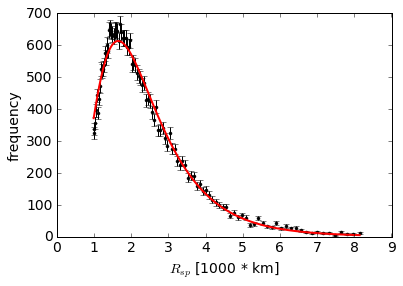

In [49]:
from astropy.constants import R_sun
import astropy.units as u

fig, ax = plt.subplots()

r_spot_km = (rspot_rstar * R_sun).to(1000 * u.km).value

ax.errorbar(r_spot_km, n_spots_per_area_bin, n_spots_per_area_bin_err, fmt='k.')
ax.plot(r_spot_km, fit_model(bestp, log_bins), color='r', lw=2)
ax.set(xlabel="$R_{sp}$ [1000 * km]", ylabel="frequency")

# for l in ax.get_xticklabels():
#     l.set_rotation(45)
#     l.set_ha('right')

# Butterfly diagram

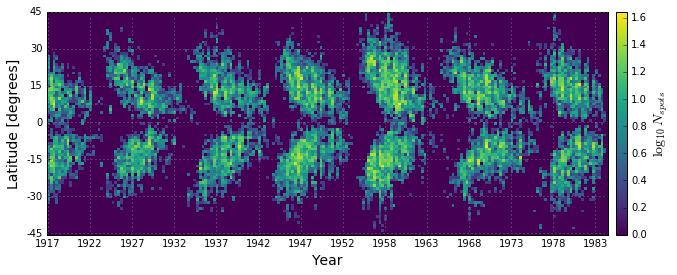

In [83]:
latitude_grid = np.linspace(-45, 45, 80)
time_grid = Time(np.linspace(Time('1917-01-01').jd, Time('1985-01-01').jd, 200), format='jd')

butterfly_grid = np.zeros((len(latitude_grid)-1, len(time_grid)))

for i in range(len(time_grid)-1):
    within_time_bin = ((table['jd'] > time_grid[i].jd) & 
                       (table['jd'] < time_grid[i+1].jd))
    spots_in_time_bin = table[within_time_bin]
    freq, edges = np.histogram(spots_in_time_bin['area_weighted_latitude_day_1'], bins=latitude_grid)
    butterfly_grid[:, i] = freq

fontsize = 14
fig, ax = plt.subplots(figsize=(14, 4))
cax = ax.imshow(np.log10(1 + butterfly_grid), cmap=plt.cm.viridis, 
                interpolation='nearest', origin='lower')
cbar = fig.colorbar(cax, pad=0.01)#, ticks=[-1, 0, 1])
cbar.ax.set_ylabel('$\log_{10} \, N_{spots}$', fontsize=fontsize)
xtickskip = 15
ax.set_xticks(list(range(len(time_grid)))[::xtickskip])
ax.set_xticklabels([i.strftime("%Y") 
                    for i in time_grid[::xtickskip].datetime])

desired_yticks = np.arange(-45, 60, 15)
ax.set_yticks(np.interp(desired_yticks, latitude_grid, np.arange(len(latitude_grid))))
ax.set_yticklabels(desired_yticks)

ax.grid(color='silver', ls=':')
ax.set_xlabel('Year', fontsize=fontsize) 
ax.set_ylabel('Latitude [degrees]', fontsize=fontsize)

fig.savefig("butterfly.png", bbox_inches='tight', dpi=200)
plt.show()